In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

In [39]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size):
    """
    Generate specific patterns for 5 modes.
    """
    pats = []
    temp_pats = create_specific_patterns4(mode1, mode2, mode3, mode4, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode5] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
def create_specific_patterns8(mode1, mode2, mode3, mode4, mode5, mode6, mode7, mode8, size):
    """
    Generate specific patterns for 8 modes.
    """
    pats = []
    temp_pats = create_specific_patterns5(mode1, mode2, mode3, mode4, mode5, size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode6] = bin_to_pattern(str(k))[0]
            for l in range(2):
                p_prime2 = copy.deepcopy(p_prime)
                p_prime2[mode7] = bin_to_pattern(str(l))[0]
                for m in range(2):
                    p_prime3 = copy.deepcopy(p_prime2)
                    p_prime3[mode8] = bin_to_pattern(str(m))[0]
                    pats.append(p_prime3)
    return pats
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(i,f)
    return f

<h2>Game modeling</h2>

In [40]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [41]:
n = 12
sequence_list = np.array([np.array(list(bin(i)[3:]),dtype=np.int32) for i in range(2**n, 2**(n+1))])
len(sequence_list)

4096

In [42]:
#Hidden Rules
def generate_rules_and_rewards(num_rules=5, rule_length=4, reward_range=(1, 20)):
    rules = set()
    rewards = []
    
    while len(rules) < num_rules:
        rule = tuple(np.random.randint(0, 2, size=rule_length))  # Utilise un tuple pour permettre l'ajout dans un set
        if rule not in rules:
            rules.add(rule)
            reward = np.random.randint(reward_range[0], reward_range[1])  # Génère une récompense aléatoire
            rewards.append(reward)
    
    return list(rules), rewards

def estimate_cost(sequence,rules,rewards):
    reward = 0

    rule_length = len(rules[0])  # Longueur des règles (toutes les règles ont la même longueur)
    
    for k in range(len(sequence) - rule_length + 1):
        for rule, rule_reward in zip(rules, rewards):
            if np.all(sequence[k:k + rule_length] == rule):
                reward += rule_reward
                break  # Une fois qu'une règle correspond, on passe à la prochaine sous-séquence
    
    return reward

<h2>Tests</h2>

In [192]:
def monte_carlo_compressive_learning(Phi,sequence_cost,sample_size=200,threshold=20):

    #Sample
    sample_index = np.random.randint(0,len(sequence_list),sample_size)
    sequence_cost_spectrum = np.zeros_like(sequence_cost)
    sequence_cost_spectrum[sample_index] = sequence_cost[sample_index]

    #Threshold
    sequence_cost_spectrum[sequence_cost_spectrum<threshold]=0

    #Measurements
    y = []
    y = np.array(Phi * np.matrix(sequence_cost_spectrum).T).T[0]
    y = np.array(y)

    #Matching pursuit
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
    omp.fit(Phi, y)
    coefficients = [ i if i>0 else 0 for i in omp.coef_]

    good_opt = np.intersect1d(np.argpartition(sequence_cost, -20)[-20:],np.nonzero(coefficients)[0])
    # print(good_opt)
    return len(good_opt)

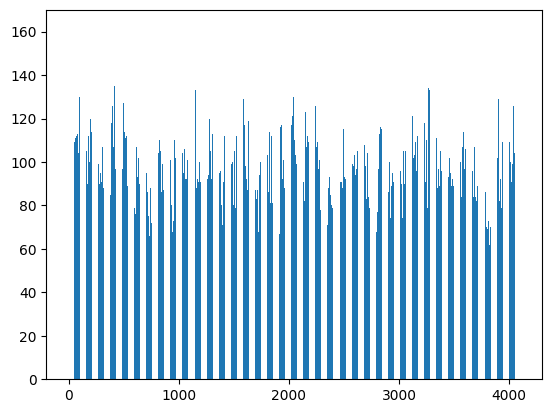

4095


In [273]:
rules, rewards = generate_rules_and_rewards(num_rules=16)

sequence_cost = []
for sequence in sequence_list:
    sequence_cost.append(estimate_cost(sequence,rules, rewards))
sequence_cost = np.array(sequence_cost)

plt.bar([i for i in np.arange(len(sequence_list))],sequence_cost,width=0.5)
plt.show()
ma = np.argmax(sequence_cost)
print(ma)
# print(sequence_list[ma])
# print(sequence_cost[ma])

In [275]:
#Random
Phi = np.random.rand(250,4096)
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(200):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

0.71

In [276]:
#Nearest neighbor pairs
all_pat = []
for i in range(n-1):
    all_pat += create_specific_patterns(i,i+1,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(300):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

0.57

In [263]:
#All pairs
all_pat = []
all_pat = []
for i in range(n):
    for j in range(i+1,n):
        all_pat += create_specific_patterns(i,j,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(200):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

/home/baptiste/Documents/.venv/lib/python3.12/site-packages/sklearn/linear_model/_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


1.285

In [264]:
#Nearest neighbor triplets
all_pat = []
for i in range(n-2):
    all_pat += create_specific_patterns3(i,i+1,i+2,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(200):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

1.58

In [265]:
#Nearest neighbor quadruplets
all_pat = []
for i in range(n-3):
    all_pat += create_specific_patterns4(i,i+1,i+2,i+3,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(200):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

1.7

In [266]:
#All quadruplets
all_pat = []
for i in range(n):
    for j in range(i+1,n):
        for k in range(j+1,n):
            for l in range(k+1,n):
                all_pat += create_specific_patterns4(i,j,k,l,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(20):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

1.25

In [267]:
#Nearest neighbor quintuplets
all_pat = []
for i in range(n-4):
    all_pat += create_specific_patterns5(i,i+1,i+2,i+3,i+4,n)
Phi = np.array([dev_pattern(p) for p in all_pat])
thresh = np.percentile(sequence_cost,90)

res = []
for _ in range(200):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

1.66

In [268]:
#Nearest neighbor octuplets
all_pat = []
for i in range(n-7):
    all_pat += create_specific_patterns8(i,i+1,i+2,i+3,i+4,i+5,i+6,i+7,n)
Phi = np.array([dev_pattern(p) for p in all_pat])

res = []
for _ in range(100):
    res.append(monte_carlo_compressive_learning(Phi,sequence_cost,threshold=thresh))
np.average(res)

0.98